In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import torch
print ('number of GPUs:', torch.cuda.device_count())

from tqdm import tqdm
from matplotlib import pyplot as plt 

from minichatgpt.experiments.imdb import config, sent_kwargs
from minichatgpt import Lab
from minichatgpt.processdata.collators import imdb_dataloader_collator

/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help` for usage information.


/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help` for usage information.




number of GPUs: 2


In [2]:
# For the sake of the speed of this demonstration, the batch_size is temporarily decreased from 256 to 4
batch_size = 64
config.batch_size = batch_size
config.forward_batch_size = batch_size//2

0

In [3]:
lab = Lab(config)

dataset = lab.build_dataset(dataset_name="imdb",input_min_text_length=2,input_max_text_length=8)

new_policy, old_policy, tokenizer = lab.init_policies_tokenizer()

lab.set_generation_config(do_sample=True,output_min_length=4,output_max_length=16,pad_token_id=tokenizer.eos_token_id)

ppo_trainer = lab.init_ppo_trainer(
    config, 
    new_policy, 
    old_policy, 
    tokenizer, 
    dataset, 
    dataloader_collator = imdb_dataloader_collator,
)

reward_model = lab.init_reward_model()

Found cached dataset imdb (/home/carson/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)
Loading cached processed dataset at /home/carson/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-a680d0720b68191d.arrow
Loading cached processed dataset at /home/carson/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-ec21da66149d9ccd.arrow


In [4]:
returns_list = []
rewards_list = []
print(new_policy.pretrained_model.device)
#print(new_policy.v_head)
#new_policy.v_head.summary.to('cuda:1')
print(new_policy.v_head.summary.weight.device)
#lab.reward_model.model.to('cuda:1')
#lab.reward_model.device = torch.device('cuda:1')
print(lab.reward_model.model.device)

cuda:0
cuda:0
cuda:0


In [27]:
"""

device_map = {
  0: [ 0, 1, 2, 3, 4, 5],
  1: [ 6, 7, 8, 9, 10, 11],
}

new_policy.pretrained_model.parallelize(device_map)
old_policy.pretrained_model.parallelize(device_map)

"""

In [ ]:
for batch_step, batch in tqdm(enumerate(ppo_trainer.dataloader)):
    
    queries = batch['input_ids']
    
    #### Get response from gpt2
    responses = []
    for query in queries:
        gen_len = lab.output_length_sampler()
        lab.generation_kwargs["max_new_tokens"] = gen_len
        response = ppo_trainer.generate(query, **lab.generation_kwargs)
        responses.append(response.squeeze()[-gen_len:])
        
    batch['response'] = [tokenizer.decode(r.squeeze()) for r in responses]
    
    #### Compute sentiment score
    texts = [q + r for q,r in zip(batch['query'], batch['response'])]
    pipe_outputs = lab.reward_model(texts, **sent_kwargs)
    
    scores = [output[1]["score"] for output in pipe_outputs]
    rewards_list.append(np.mean(scores))
    
    rewards = [torch.tensor(score) for score in scores]
    #rewards = [r.to(new_policy.pretrained_model.device) for r in rewards]
    #rewards = [r.to(new_policy.v_head.summary.weight.device) for r in rewards]
    
    #### Run PPO step 
    stats = ppo_trainer.step(queries, responses, rewards)
    ppo_trainer.log_stats(stats, batch, rewards)
    
    returns_list.append(stats['ppo/returns/mean'])
    
    #break

1it [00:20, 20.84s/it]

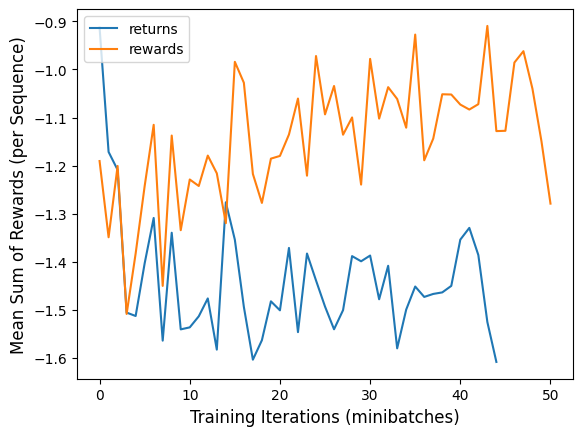

In [29]:
plt.figure()
plt.xlabel('Training Iterations (minibatches)', fontsize=12)
plt.ylabel('Mean Sum of Rewards (per Sequence)', fontsize=12)
plt.plot(returns_list, label='returns')
plt.plot(rewards_list, label='rewards')
plt.legend()
plt.show()

In [8]:
#stats = ppo_trainer.step(queries, responses, rewards)

ppo_trainer.accelerator.device

device(type='cuda')

In [9]:
queries

[tensor([  40, 3505, 4964,  366,   38], device='cuda:0'),
 tensor([  40, 3521], device='cuda:0'),
 tensor([   32, 43527,   913, 32251,   326], device='cuda:0'),
 tensor([   40,   588, 10530], device='cuda:0'),
 tensor([2025, 8674, 7893,   11,  366, 2061,  338], device='cuda:0'),
 tensor([  40,  423,  655, 7342,  262, 2187], device='cuda:0'),
 tensor([  40, 3636], device='cuda:0'),
 tensor([   1, 5317, 2021, 7276,    1,  416], device='cuda:0'),
 tensor([ 3666, 41991,  6065], device='cuda:0'),
 tensor([  32, 1913, 8022,   11,  428,  734], device='cuda:0'),
 tensor([1026,  318], device='cuda:0'),
 tensor([5574, 6888, 4940,  355], device='cuda:0'),
 tensor([  40, 2331,  287], device='cuda:0'),
 tensor([26554,   644], device='cuda:0'),
 tensor([ 32, 845], device='cuda:0'),
 tensor([  40, 1807], device='cuda:0'),
 tensor([1212, 3807], device='cuda:0'),
 tensor([  40, 3505,  428, 2168,  523], device='cuda:0'),
 tensor([3546,  262], device='cuda:0'),
 tensor([1212, 3807,  318, 1107,  922], dev

In [10]:
responses

[tensor([27725,   286,   968,  1971,     1,   379,   257,  2318,    11],
        device='cuda:0'),
 tensor([ 470, 1650,  832,  428], device='cuda:0'),
 tensor([ 7622,   345,   422, 12598,   262, 15413,  1605], device='cuda:0'),
 tensor([ 6918,   828,   290,   314,  1549,   587,  2045,   329,  1194, 18304,
            13, 28796,  1106,  3941, 21429], device='cuda:0'),
 tensor([  351,   262, 31644,  1701, 24262,    11,   262], device='cuda:0'),
 tensor([ 1517,   287,   616, 17012,    13,  3982,   521,   276,   502,   286,
           262], device='cuda:0'),
 tensor([ 470,  765,  284,  670,  734, 2250,  530, 1285,   11,  523,  314, 1410,
          284], device='cuda:0'),
 tensor([  416,  5966, 11696,   316, 30552,  2014, 50256], device='cuda:0'),
 tensor([ 553,  366, 6836, 1653, 2097,    1,  357,   49,  964], device='cuda:0'),
 tensor([1621, 1011,  286,  262, 1175, 4325], device='cuda:0'),
 tensor([  257, 23056,  1487,   618, 10448,   422,   262,  6650],
        device='cuda:0'),
 tensor([

In [11]:
queries

[tensor([  40, 3505, 4964,  366,   38], device='cuda:0'),
 tensor([  40, 3521], device='cuda:0'),
 tensor([   32, 43527,   913, 32251,   326], device='cuda:0'),
 tensor([   40,   588, 10530], device='cuda:0'),
 tensor([2025, 8674, 7893,   11,  366, 2061,  338], device='cuda:0'),
 tensor([  40,  423,  655, 7342,  262, 2187], device='cuda:0'),
 tensor([  40, 3636], device='cuda:0'),
 tensor([   1, 5317, 2021, 7276,    1,  416], device='cuda:0'),
 tensor([ 3666, 41991,  6065], device='cuda:0'),
 tensor([  32, 1913, 8022,   11,  428,  734], device='cuda:0'),
 tensor([1026,  318], device='cuda:0'),
 tensor([5574, 6888, 4940,  355], device='cuda:0'),
 tensor([  40, 2331,  287], device='cuda:0'),
 tensor([26554,   644], device='cuda:0'),
 tensor([ 32, 845], device='cuda:0'),
 tensor([  40, 1807], device='cuda:0'),
 tensor([1212, 3807], device='cuda:0'),
 tensor([  40, 3505,  428, 2168,  523], device='cuda:0'),
 tensor([3546,  262], device='cuda:0'),
 tensor([1212, 3807,  318, 1107,  922], dev

In [12]:
rewards

[tensor(-0.8167, device='cuda:0'),
 tensor(-2.4185, device='cuda:0'),
 tensor(-2.4066, device='cuda:0'),
 tensor(-0.3301, device='cuda:0'),
 tensor(-1.3618, device='cuda:0'),
 tensor(-1.3298, device='cuda:0'),
 tensor(-0.2549, device='cuda:0'),
 tensor(-0.2748, device='cuda:0'),
 tensor(-0.0911, device='cuda:0'),
 tensor(-1.8039, device='cuda:0'),
 tensor(-2.5575, device='cuda:0'),
 tensor(-0.7393, device='cuda:0'),
 tensor(-1.1953, device='cuda:0'),
 tensor(-0.2389, device='cuda:0'),
 tensor(-2.5022, device='cuda:0'),
 tensor(-0.9194, device='cuda:0'),
 tensor(-0.2826, device='cuda:0'),
 tensor(-2.0877, device='cuda:0'),
 tensor(-2.5105, device='cuda:0'),
 tensor(-2.4504, device='cuda:0'),
 tensor(-0.4211, device='cuda:0'),
 tensor(-0.4106, device='cuda:0'),
 tensor(-0.9187, device='cuda:0'),
 tensor(-0.3239, device='cuda:0'),
 tensor(-0.8487, device='cuda:0'),
 tensor(-2.4242, device='cuda:0'),
 tensor(-0.3864, device='cuda:0'),
 tensor(-0.5218, device='cuda:0'),
 tensor(-0.3202, dev